# Notes

In [ ]:
# ref: https://huggingface.co/transformers/v3.3.1/pretrained_models.html

# Import modules

In [25]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np

import sys
sys.path.append('../')
from src.config import *
from src.helper_visualization import *
from src.helper_pred import *
from src.helper_pipeline import *

from datasets import Dataset
from sklearn.metrics import accuracy_score, classification_report

# Load Train Data

df_train has 90197 records, memory usage: 6MB


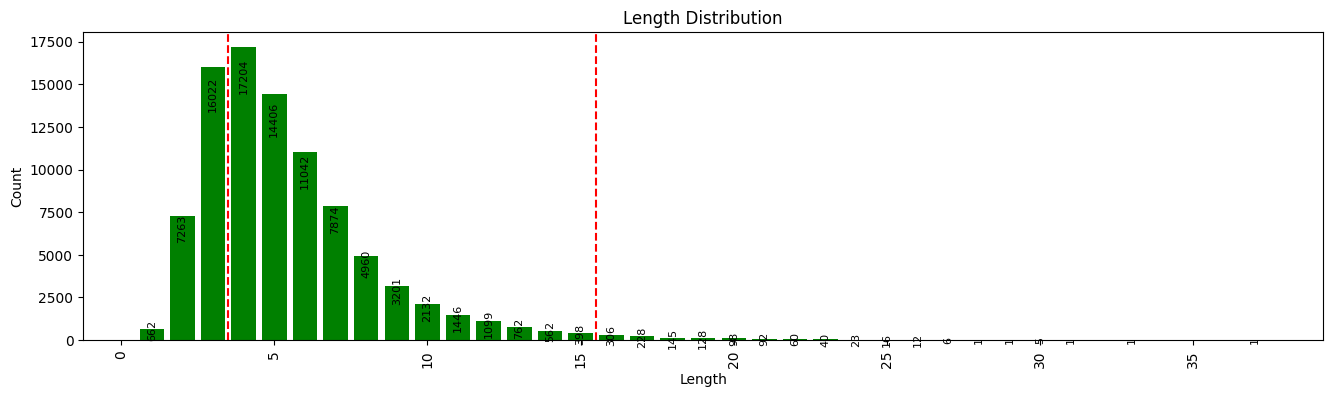

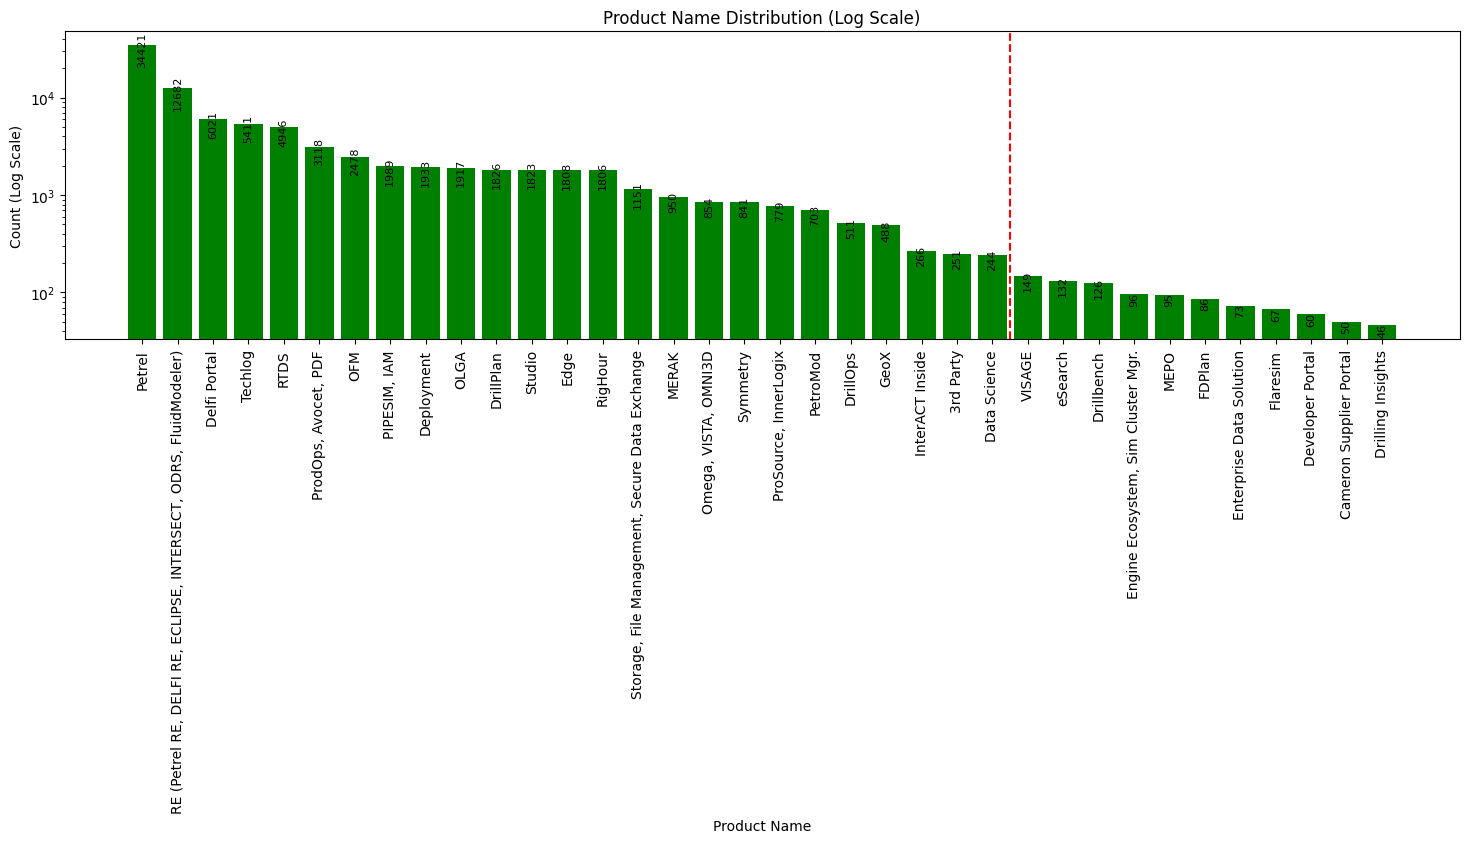

In [27]:
# Define GLOBAL variables for data preparation
TITLE_WORDS_MIN = 4             # the minimum number of words in the title
TITLE_WORDS_MAX = 15            # the maximum number of words in the title
TEXT_COL = 'Title_Translated'     # the text column to be used for training
TARGET_COL = 'Product Name'     # the target column to be used for training

PRODUCT_SIZE_MAX_TRAIN = 5000   # the maximum number of samples for each product in training set to balance the data
PRODUCT_SIZE_MAX_TEST = 500     # the maximum number of samples for each product in test set to balance the data
TOP_N_PRODUCTS = 25

if 'df_train' not in locals():
    excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'
    df_train = pd.read_excel(excel_file_train)
print(f'df_train has \033[94m{df_train.shape[0]}\033[0m records, memory usage: \033[94m{df_train.memory_usage().sum()//(1024*1024)}\033[0mMB')

hist_by_labels(df_train, 'Length', log=False, left=TITLE_WORDS_MIN-.5, right=TITLE_WORDS_MAX+.5)
hist_by_labels(df_train, 'Product Name', log=True, right=TOP_N_PRODUCTS-.5)
df_train.sample(10, random_state=42)

# Get the Product Name list of Top N products
def get_top_n_products(df, target_col, n):
    df_target = df[target_col].value_counts().to_frame().reset_index()
    df_target.columns = [target_col, 'count']
    df_target = df_target.sort_values(by='count', ascending=False)
    df_target = df_target.head(n)
    return df_target[target_col].tolist()

top_n_products = get_top_n_products(df_train, TARGET_COL, TOP_N_PRODUCTS)

# Data Processing

Define the data preparation pipeline

In [28]:
# create a scikit-learn pipeline to remove the title with less than 3 words or more than 20 words
pipleline_data_prep_train = Pipeline([
    ('title_length_filter', TitleLengthFilter(min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX)),
    ('other_products_combiner', OtherProductsCombiner(top_products=top_n_products, target_col=TARGET_COL)),
    ('sample_capper', SampleCapper(max_samples=PRODUCT_SIZE_MAX_TRAIN, target_col=TARGET_COL)),
    ('text_lower', TextLower(text_col=TEXT_COL))
])

pipleline_data_prep_test = Pipeline([
    ('title_length_filter', TitleLengthFilter(min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX)),
    ('other_products_combiner', OtherProductsCombiner(top_products=top_n_products, target_col=TARGET_COL)),
    ('sample_capper', SampleCapper(max_samples=PRODUCT_SIZE_MAX_TEST, target_col=TARGET_COL)),
    ('text_lower', TextLower(text_col=TEXT_COL))
])

display(pipleline_data_prep_train)
display(pipleline_data_prep_test)

Pipeline(steps=[('title_length_filter',
                 TitleLengthFilter(max_words=15, min_words=4)),
                ('other_products_combiner',
                 OtherProductsCombiner(target_col='Product Name',
                                       top_products=['Petrel',
                                                     'RE (Petrel RE, DELFI RE, '
                                                     'ECLIPSE, INTERSECT, '
                                                     'ODRS, FluidModeler)',
                                                     'Delfi Portal', 'Techlog',
                                                     'RTDS',
                                                     'ProdOps, Avocet, PDF',
                                                     'OFM', 'PIPESIM, IAM',
                                                     'Deployment', 'OLGA',
                                                     'DrillPlan', 'Studio',
                                                     'Edge', 'RigHour',
                                                     'Storage, File '
                                                     'Management, Secure Data '
                                                     'Exchange',
                                                     'MERAK',
                                                     'Omega, VISTA, OMNI3D',
                                                     'Symmetry',
                                                     'ProSource, InnerLogix',
                                                     'PetroMod', 'DrillOps',
                                                     'GeoX', 'InterACT Inside',
                                                     '3rd Party',
                                                     'Data Science'])),
                ('sample_capper',
                 SampleCapper(max_samples=5000, target_col='Product Name')),
                ('text_lower', TextLower(text_col='Title_Translated'))])

Pipeline(steps=[('title_length_filter',
                 TitleLengthFilter(max_words=15, min_words=4)),
                ('other_products_combiner',
                 OtherProductsCombiner(target_col='Product Name',
                                       top_products=['Petrel',
                                                     'RE (Petrel RE, DELFI RE, '
                                                     'ECLIPSE, INTERSECT, '
                                                     'ODRS, FluidModeler)',
                                                     'Delfi Portal', 'Techlog',
                                                     'RTDS',
                                                     'ProdOps, Avocet, PDF',
                                                     'OFM', 'PIPESIM, IAM',
                                                     'Deployment', 'OLGA',
                                                     'DrillPlan', 'Studio',
                                                     'Edge', 'RigHour',
                                                     'Storage, File '
                                                     'Management, Secure Data '
                                                     'Exchange',
                                                     'MERAK',
                                                     'Omega, VISTA, OMNI3D',
                                                     'Symmetry',
                                                     'ProSource, InnerLogix',
                                                     'PetroMod', 'DrillOps',
                                                     'GeoX', 'InterACT Inside',
                                                     '3rd Party',
                                                     'Data Science'])),
                ('sample_capper',
                 SampleCapper(max_samples=500, target_col='Product Name')),
                ('text_lower', TextLower(text_col='Title_Translated'))])

Prepare data for the trainer

In [29]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Encode the target labels
le = LabelEncoder()

# Train data
df_train_processed = pipleline_data_prep_train.fit_transform(df_train)
df_train_processed = df_train_processed.reset_index(drop=True)
df_train_processed = df_train_processed.rename(columns={TEXT_COL: 'text'})
df_train_processed['label'] = le.fit_transform(df_train_processed[TARGET_COL])
print(f'Train data has \033[94m{df_train_processed.shape[0]}\033[0m records, memory usage: \033[94m{df_train_processed.memory_usage().sum()//(1024*1024)}\033[0m MB')
display(df_train_processed.head())

Train data has 41617 records, memory usage: 3 MB


,Request ID,Title,Product Name,Title_Processed,Language,Length,text,Title_Enhanced,Tags,label
0,1699372,[Ext] Excel To PEEP loader license for 2023,MERAK,Excel To PEEP loader license for,en,4,excel to peep loader license for,Excel PEEP loader license,loader excel license peep,9
1,1294141,IWC Saudi <AAdy@slb.com> NAO BP Deepwater bit ...,RigHour,IWC Saudi NAO BP Deepwater bit size and Casing...,en,10,iwc saudi nao bp deepwater bit size and casing...,integrated well construction ( IWC ) NAO Deepw...,integrated casing nao construction bit deepwat...,21
2,1195512,Wells disappeared from wells Section.,"ProdOps, Avocet, PDF",Wells disappeared from wells Section.,en,4,wells disappeared from wells section.,Wells disappeared wells Section,well disappeared section,18
3,1959644,include extra data inside OFM,OFM,include extra data inside OFM,en,8,include extra data inside ofm,include extra data inside oil field management...,include management extra field ofm inside oil ...,10
4,623172,Bulk renaming Faults in Studio,Studio,Bulk renaming Faults in Studio,en,4,bulk renaming faults in studio,Bulk renaming Faults Studio,renaming fault studio bulk,23


# Hugging Face Transformer

In [22]:
# import Hugging Face transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import evaluate     # helper functions to used in trainer callback to compute accuracy, precision, recall, f1 during training

## Training

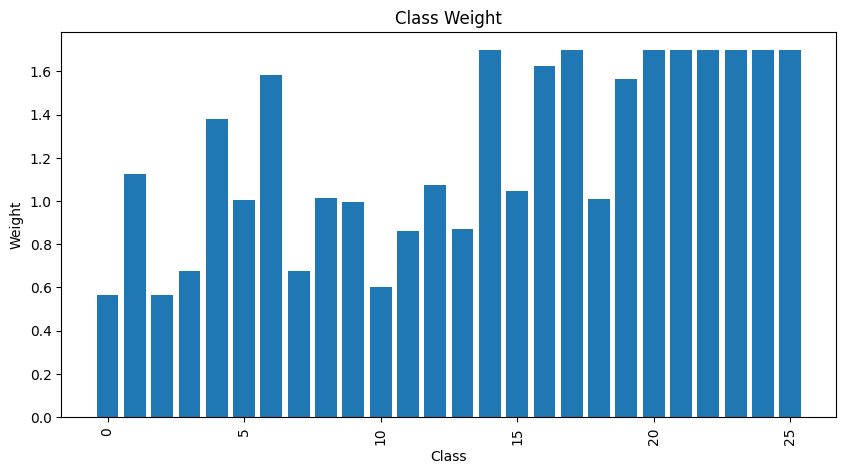

Map:   0%|          | 0/35374 [00:00<?, ? examples/s]

Map:   0%|          | 0/6243 [00:00<?, ? examples/s]

In [42]:
# CONGRATULATIONS, ready to go 🚀
# ref: https://huggingface.co/transformers/v3.3.1/pretrained_models.html
# BERT_MODEL = 'bert-base-uncased' # 12-layer, 768-hidden, 12-heads, 110M parameters. Trained on lower-cased English text.
BERT_MODEL = 'distilbert-base-uncased' # 6-layer, 768-hidden, 12-heads, 66M parameters. Trained on lower-cased English text.
MAX_EPOCH = 50
EARLY_STOP_PATIENCE = 5
BATCH_SIZE = 128
FRACTION = 1
# CONGRATULATIONS, ready to go 🚀

tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
def tokenize(batch):
    return tokenizer(batch['text'], 
                    max_length=TITLE_WORDS_MAX,
                    padding='max_length', 
                    truncation=True)

# Split train data into train and eval
train_data = df_train_processed[['text', 'label']]
train_data, eval_data = train_test_split(train_data, test_size=0.15, stratify=train_data['label'], random_state=42)

# Sample the train and eval data to speed up the training
train_data = train_data.sample(frac=FRACTION, random_state=42).reset_index(drop=True)
eval_data = eval_data.sample(frac=FRACTION, random_state=42).reset_index(drop=True)

# Get the number of classes
n_classes = len(train_data.label.unique())

# Class weighting
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=train_data.label.unique(), y=train_data.label)
class_weight_max = np.sqrt(class_weights.min())*3
class_weights = {i: min(np.sqrt(class_weights[i]), class_weight_max) for i in range(len(class_weights))}
plot_class_weights(class_weights)

hg_train_data = Dataset.from_pandas(train_data)
hg_eval_data = Dataset.from_pandas(eval_data)

# Tokenize the train and eval data
hg_train_data_tokenized = hg_train_data.map(tokenize)
hg_eval_data_tokenized = hg_eval_data.map(tokenize)

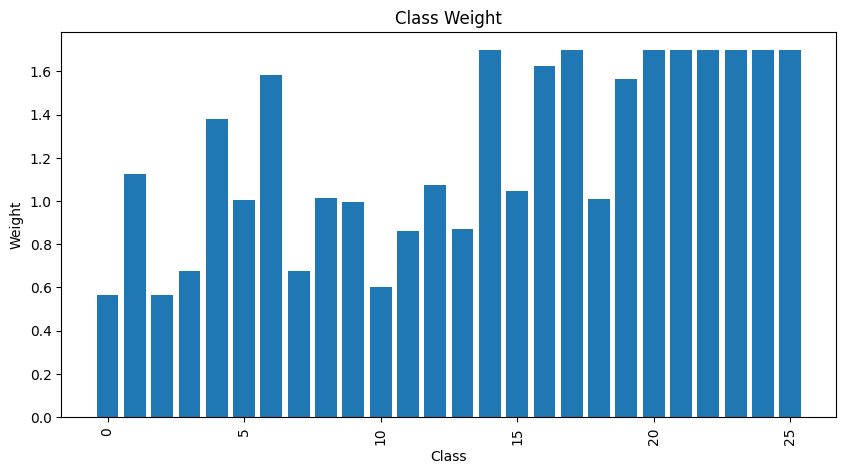

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train data has 35374 records; Eval data has 6243 records
100.0% data used - Train_data has 35374 records; Eval_data has 6243 records
Using distilbert-base-uncased model, Epoch=50, Early Stop Patience=5, Batch Size=128.


  0%|          | 0/13850 [00:00<?, ?it/s]

{'loss': 2.9004, 'learning_rate': 2.7700000000000006e-06, 'epoch': 1.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 2.4045143127441406, 'eval_accuracy': 0.158097068716963, 'eval_runtime': 19.2338, 'eval_samples_per_second': 324.585, 'eval_steps_per_second': 2.548, 'epoch': 1.0}
{'loss': 1.9124, 'learning_rate': 4.979775280898877e-06, 'epoch': 2.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 1.4426918029785156, 'eval_accuracy': 0.3573602434726894, 'eval_runtime': 7.614, 'eval_samples_per_second': 819.942, 'eval_steps_per_second': 6.436, 'epoch': 2.0}
{'loss': 1.2799, 'learning_rate': 4.876029962546817e-06, 'epoch': 3.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 1.0970879793167114, 'eval_accuracy': 0.4553900368412622, 'eval_runtime': 5.574, 'eval_samples_per_second': 1120.026, 'eval_steps_per_second': 8.791, 'epoch': 3.0}
{'loss': 1.0239, 'learning_rate': 4.772284644194756e-06, 'epoch': 4.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.9358375072479248, 'eval_accuracy': 0.5193016178119494, 'eval_runtime': 6.6871, 'eval_samples_per_second': 933.593, 'eval_steps_per_second': 7.328, 'epoch': 4.0}
{'loss': 0.8915, 'learning_rate': 4.668539325842697e-06, 'epoch': 5.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.860661506652832, 'eval_accuracy': 0.5476533717763895, 'eval_runtime': 6.5774, 'eval_samples_per_second': 949.16, 'eval_steps_per_second': 7.45, 'epoch': 5.0}
{'loss': 0.7996, 'learning_rate': 4.564794007490637e-06, 'epoch': 6.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.805080771446228, 'eval_accuracy': 0.5902610924235143, 'eval_runtime': 8.6955, 'eval_samples_per_second': 717.957, 'eval_steps_per_second': 5.635, 'epoch': 6.0}
{'loss': 0.7364, 'learning_rate': 4.461048689138577e-06, 'epoch': 7.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.7659184336662292, 'eval_accuracy': 0.6142880025628704, 'eval_runtime': 6.7506, 'eval_samples_per_second': 924.811, 'eval_steps_per_second': 7.259, 'epoch': 7.0}
{'loss': 0.678, 'learning_rate': 4.357303370786517e-06, 'epoch': 8.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.7520818710327148, 'eval_accuracy': 0.6330289924715682, 'eval_runtime': 7.1782, 'eval_samples_per_second': 869.722, 'eval_steps_per_second': 6.826, 'epoch': 8.0}
{'loss': 0.6342, 'learning_rate': 4.253558052434457e-06, 'epoch': 9.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.7156146168708801, 'eval_accuracy': 0.6506487265737626, 'eval_runtime': 6.0985, 'eval_samples_per_second': 1023.7, 'eval_steps_per_second': 8.035, 'epoch': 9.0}
{'loss': 0.5901, 'learning_rate': 4.149812734082397e-06, 'epoch': 10.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.7021551728248596, 'eval_accuracy': 0.663783437449944, 'eval_runtime': 8.7584, 'eval_samples_per_second': 712.802, 'eval_steps_per_second': 5.595, 'epoch': 10.0}
{'loss': 0.5547, 'learning_rate': 4.046067415730337e-06, 'epoch': 11.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.6878682971000671, 'eval_accuracy': 0.6783597629344866, 'eval_runtime': 11.1652, 'eval_samples_per_second': 559.148, 'eval_steps_per_second': 4.389, 'epoch': 11.0}
{'loss': 0.5231, 'learning_rate': 3.942322097378277e-06, 'epoch': 12.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.6684863567352295, 'eval_accuracy': 0.6790004805382028, 'eval_runtime': 6.4589, 'eval_samples_per_second': 966.579, 'eval_steps_per_second': 7.586, 'epoch': 12.0}
{'loss': 0.4918, 'learning_rate': 3.838576779026217e-06, 'epoch': 13.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.6823880076408386, 'eval_accuracy': 0.6911741150088099, 'eval_runtime': 6.079, 'eval_samples_per_second': 1026.98, 'eval_steps_per_second': 8.061, 'epoch': 13.0}
{'loss': 0.4644, 'learning_rate': 3.7348314606741578e-06, 'epoch': 14.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.659756600856781, 'eval_accuracy': 0.6987025468524748, 'eval_runtime': 6.9601, 'eval_samples_per_second': 896.972, 'eval_steps_per_second': 7.04, 'epoch': 14.0}
{'loss': 0.4372, 'learning_rate': 3.6310861423220976e-06, 'epoch': 15.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.6574839353561401, 'eval_accuracy': 0.7006246996636233, 'eval_runtime': 5.8688, 'eval_samples_per_second': 1063.761, 'eval_steps_per_second': 8.349, 'epoch': 15.0}
{'loss': 0.4169, 'learning_rate': 3.527340823970038e-06, 'epoch': 16.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.6563301086425781, 'eval_accuracy': 0.7065513374979978, 'eval_runtime': 7.1206, 'eval_samples_per_second': 876.755, 'eval_steps_per_second': 6.881, 'epoch': 16.0}
{'loss': 0.394, 'learning_rate': 3.4235955056179777e-06, 'epoch': 17.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.6612895727157593, 'eval_accuracy': 0.7119974371295852, 'eval_runtime': 6.9795, 'eval_samples_per_second': 894.48, 'eval_steps_per_second': 7.021, 'epoch': 17.0}
{'loss': 0.3771, 'learning_rate': 3.319850187265918e-06, 'epoch': 18.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.66355961561203, 'eval_accuracy': 0.7134390517379465, 'eval_runtime': 9.0668, 'eval_samples_per_second': 688.558, 'eval_steps_per_second': 5.404, 'epoch': 18.0}
{'loss': 0.3595, 'learning_rate': 3.216104868913858e-06, 'epoch': 19.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.6535292863845825, 'eval_accuracy': 0.7166426397565273, 'eval_runtime': 8.0599, 'eval_samples_per_second': 774.575, 'eval_steps_per_second': 6.079, 'epoch': 19.0}
{'loss': 0.3468, 'learning_rate': 3.112359550561798e-06, 'epoch': 20.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.6811540722846985, 'eval_accuracy': 0.723530353996476, 'eval_runtime': 6.5128, 'eval_samples_per_second': 958.573, 'eval_steps_per_second': 7.524, 'epoch': 20.0}
{'loss': 0.3324, 'learning_rate': 3.008614232209738e-06, 'epoch': 21.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.663635790348053, 'eval_accuracy': 0.7268941214159859, 'eval_runtime': 6.3735, 'eval_samples_per_second': 979.525, 'eval_steps_per_second': 7.688, 'epoch': 21.0}
{'loss': 0.3173, 'learning_rate': 2.904868913857678e-06, 'epoch': 22.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.6681163907051086, 'eval_accuracy': 0.7248117892039084, 'eval_runtime': 6.7191, 'eval_samples_per_second': 929.149, 'eval_steps_per_second': 7.293, 'epoch': 22.0}
{'loss': 0.3054, 'learning_rate': 2.801123595505618e-06, 'epoch': 23.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.6811648011207581, 'eval_accuracy': 0.7304180682364247, 'eval_runtime': 5.468, 'eval_samples_per_second': 1141.74, 'eval_steps_per_second': 8.961, 'epoch': 23.0}
{'loss': 0.2951, 'learning_rate': 2.6973782771535583e-06, 'epoch': 24.0}


  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.6741189360618591, 'eval_accuracy': 0.7328207592503604, 'eval_runtime': 5.8126, 'eval_samples_per_second': 1074.052, 'eval_steps_per_second': 8.43, 'epoch': 24.0}
{'train_runtime': 2127.4543, 'train_samples_per_second': 831.369, 'train_steps_per_second': 6.51, 'train_loss': 0.7109177425306483, 'epoch': 24.0}


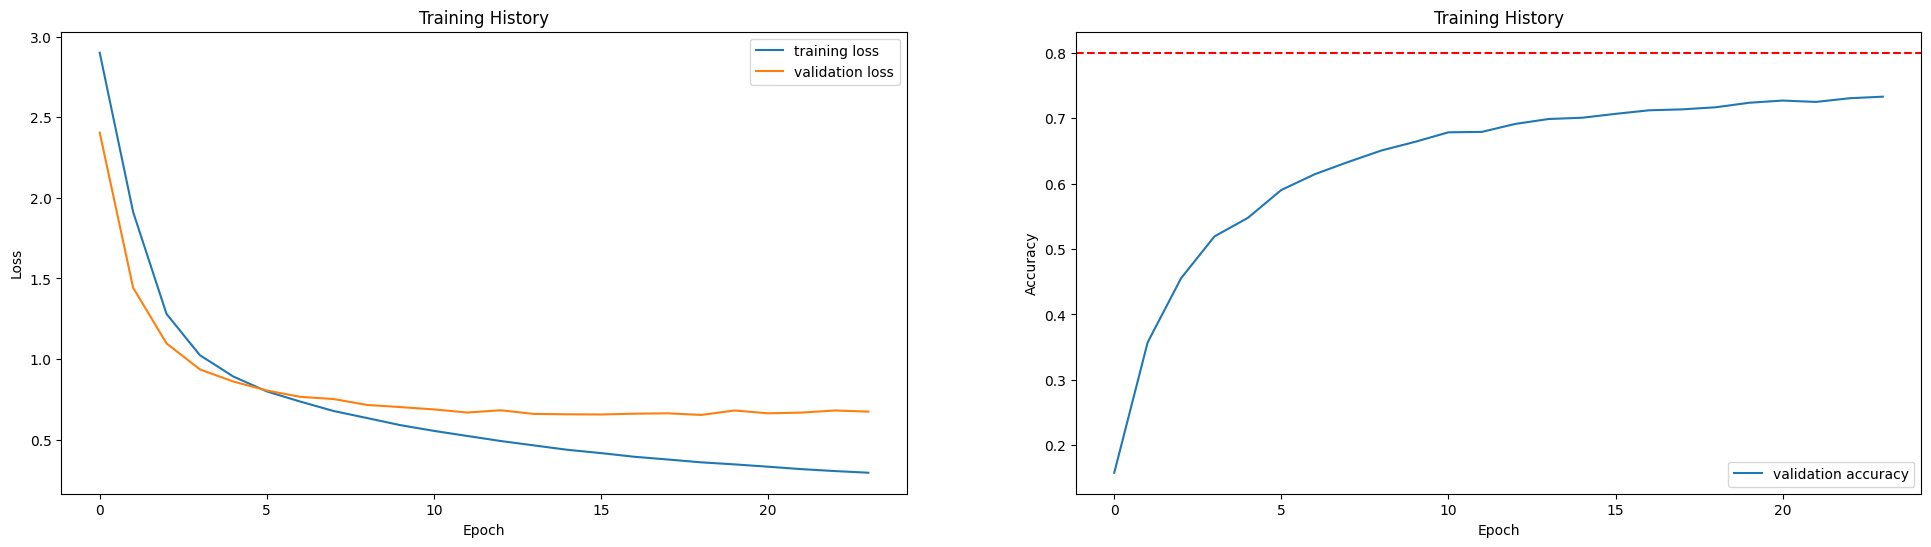

  0%|          | 0/49 [00:00<?, ?it/s]

{'eval_loss': 0.6535292863845825,
 'eval_accuracy': 0.7166426397565273,
 'eval_runtime': 5.3723,
 'eval_samples_per_second': 1162.064,
 'eval_steps_per_second': 9.121,
 'epoch': 24.0}

In [24]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=n_classes)

# Define the training arguments
training_args = TrainingArguments(
    num_train_epochs=MAX_EPOCH,                 # total number of training epochs
    output_dir='./results',                     # output directory
    logging_dir='./logs',                       # directory for storing logs
    logging_strategy='epoch',                   # log every epoch
    logging_steps=100,                          # log every 100 steps
    warmup_steps=500,                           # number of warmup steps for learning rate scheduler
    per_device_train_batch_size=BATCH_SIZE,     # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,      # batch size for evaluation
    learning_rate=5e-6,                         # learning rate
    seed=42,                                    # seed for reproducibility
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

# Define the compute_metrics function to compute the accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric = evaluate.load('accuracy')
    accuracy = metric.compute(predictions=predictions, references=labels)
    return accuracy

import torch
from torch import nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(list(class_weights.values()), dtype=torch.float32).to(model.device))
        
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Create the Trainer instance to train the model
trainer = CustomTrainer(
    model=model,                            # the instantiated 🤗 Transformers model to be trained
    args=training_args,                     # training arguments, defined above
    train_dataset=hg_train_data_tokenized,  # training dataset
    eval_dataset=hg_eval_data_tokenized,    # evaluation dataset
    compute_metrics=compute_metrics,        # the callback that computes metrics of interest
    callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOP_PATIENCE)])

# trainer = Trainer(
#     model=model,                            # the instantiated 🤗 Transformers model to be trained
#     args=training_args,                     # training arguments, defined above
#     train_dataset=hg_train_data_tokenized,  # training dataset
#     eval_dataset=hg_eval_data_tokenized,    # evaluation dataset
#     compute_metrics=compute_metrics,        # the callback that computes metrics of interest
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=EARLY_STOP_PATIENCE)])
print(f'Train data has \033[94m{train_data.shape[0]}\033[0m records; Eval data has \033[94m{eval_data.shape[0]}\033[0m records')
print(f'\033[94m{FRACTION*100:.1f}%\033[0m data used - Train_data has \033[94m{train_data.shape[0]}\033[0m records; Eval_data has \033[94m{eval_data.shape[0]}\033[0m records')
print(f'Using \033[94m{BERT_MODEL}\033[0m model, Epoch=\033[94m{MAX_EPOCH}\033[0m, Early Stop Patience=\033[94m{EARLY_STOP_PATIENCE}\033[0m, Batch Size=\033[94m{BATCH_SIZE}\033[0m.')

trainer.train()

# Plot the training history and perform evaluation on the eval dataset
plot_transformer_training_history(trainer)
trainer.evaluate()

## Evaluate on test data

In [9]:
# Load test data
if 'df_test' not in locals():
    excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'
    df_test = pd.read_excel(excel_file_test)

df_test_processed = pipleline_data_prep_test.fit_transform(df_test)
df_test_processed = df_test_processed.reset_index(drop=True)
df_test_processed = df_test_processed.rename(columns={TEXT_COL: 'text'})
df_test_processed['label'] = le.transform(df_test_processed[TARGET_COL])
display(df_test_processed.head())

# evaluate on test data
test_data = df_test_processed[['text', 'label']]
display(test_data.head())
print(f'Test data has \033[94m{test_data.shape[0]}\033[0m records.')

hg_test_data = Dataset.from_pandas(test_data)
hg_test_data_tokenized = hg_test_data.map(tokenize)

y_actual = hg_test_data_tokenized['label']
y_pred = trainer.predict(hg_test_data_tokenized)
y_pred = np.argmax(y_pred.predictions, axis=-1)

accuracy = accuracy_score(y_actual, y_pred)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_actual, y_pred, digits=3, target_names=le.classes_)
print(report)

y_actual_decoded = le.inverse_transform(y_actual)
y_pred_decoded = le.inverse_transform(y_pred)
plot_confusion_matrix(y_actual_decoded, y_pred_decoded)

,Request ID,Title,Product Name,Title_Processed,Language,Length,text,Title_Enhanced,Tags,label
0,564354,Issue with well RAAG 54 - Cairn,RigHour,Issue with well RAAG Cairn,en,3,issue with well raag cairn,well RAAG Cairn,well cairn raag,21
1,2568681,PetroMod: how to define calibration points tha...,PetroMod,PetroMod how to define calibration points that...,en,8,petromod how to define calibration points that...,PetroMod define calibration points want includ...,include risk model calibration point define wa...,16
2,1585475,PD#1840186 | 1-1PRD91R | DELFI- Solutions & Se...,Delfi Portal,DELFI Solutions & Services Support TGX issue c...,en,6,delfi solutions & services support tgx issue c...,DELFI Solutions Services TGX certificate expired,tgx delfi solution certificate expired service,2
3,1260582,Petrel: 断层上下盘拆分问题,Petrel,Petrel 断层上下盘拆分问题,zh,6,the problem of separation of the upper and low...,separation upper lower walls Petrel fault,petrel separation lower wall upper fault,15
4,1224196,[Ext] Slow Petrel project,Petrel,Slow Petrel project,en,3,slow petrel project,Slow Petrel project,slow petrel project,15


,text,label
0,issue with well raag cairn,21
1,petromod how to define calibration points that...,16
2,delfi solutions & services support tgx issue c...,2
3,the problem of separation of the upper and low...,15
4,slow petrel project,15


Test data has 5116 records.


Map:   0%|          | 0/5116 [00:00<?, ? examples/s]

  0%|          | 0/320 [00:00<?, ?it/s]

Accuracy: 0.7357


ValueError: Number of classes, 25, does not match size of target_names, 26. Try specifying the labels parameter

# Word2Vec

In [ ]:
from gensim.models import Word2Vec
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
import optuna

# Load the pre-trained Word2Vec model
import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')

# train the word2vec_model using additional X_train data
# word2vec_model.build_vocab(X_train, update=True)
word2vec_model.train(X_train, total_examples=word2vec_model.corpus_count, epochs=word2vec_model.epochs)

# Define a function to encode the text using Word2Vec
def encode_text(text):
    words = text.split()
    vectors = []
    for word in words:
        if word in word2vec_model:
            vector = word2vec_model[word]
            vectors.append(vector)
    if len(vectors) == 0:
        return np.zeros(dim) # Return a vector of zeros if no words are found
    else:
        return np.mean(vectors, axis=0) # Return the mean of the word vectors

# Vectorize the training and testing data using Word2Vec
X_train_word2vec = [encode_text(text) for text in X_train]
X_test_word2vec = [encode_text(text) for text in X_test]


# Clean up the study if it exists
study_name = 'sgd_classifier_word2vec'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_word2vec, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)


In [ ]:

# Vectorize the training and testing data using Word2Vec
X_train_word2vec = [encode_text(text) for text in X_train]
X_test_word2vec = [encode_text(text) for text in X_test]


# Clean up the study if it exists
study_name = 'sgd_classifier_word2vec'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_word2vec, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)


In [ ]:
import gensim
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Load the pre-trained Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format(f'{MODEL_FOLDER_PATH}/word2vec/GoogleNews-vectors-negative300.bin', binary=True, limit=200000)


In [ ]:
# Load the pre-trained GloVe embeddings
embeddings_index = {}
dim = 300

with open(f'{MODEL_FOLDER_PATH}/glove/glove.6B.{dim}d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Define a function to encode the text using GloVe
def encode_text(text):
    words = text.split()
    vectors = []
    for word in words:
        if word in embeddings_index:
            vector = embeddings_index[word]
            vectors.append(vector)
    if len(vectors) == 0:
        return np.zeros(dim) # Return a vector of zeros if no words are found
    else:
        return np.mean(vectors, axis=0) # Return the mean of the word vectors

# Vectorize the training and testing data using GloVe
X_train_glove = [encode_text(text) for text in X_train]
X_test_glove = [encode_text(text) for text in X_test]

# Tensorflow

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_core as keras
import keras_nlp

print('Tensorflow version:', tf.__version__)
print('KerasNLP version:', keras_nlp.__version__)

In [ ]:
BATCH_SIZE = 32
NUM_TRAIN_SAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = NUM_TRAIN_SAMPLES * TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 3
AUTO = tf.data.experimental.AUTOTUNE

In [ ]:
from sklearn.model_selection import train_test_split

X = X_train
y = y_train

# encode the target
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)


In [ ]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"
NUM_CLASSES = len(df_train['Product Name'].unique())

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset, sequence_length=160, name="preprocessor_4_tweets")

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset, preprocessor = preprocessor, num_classes=NUM_CLASSES)

classifier.summary()

In [ ]:
# Compile the model
classifier.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-5),
    metrics=['accuracy'])

# Fit the model.
history = classifier.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val)
    )

In [ ]:
# plot the training history
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test data
y_pred_tf = classifier.predict(X_test)
y_pred_tf = np.argmax(y_pred_tf, axis=1)

# Decode the predictions
y_pred_tf = label_encoder.inverse_transform(y_pred_tf)

# Evaluate the model on the test data

accuracy = accuracy_score(y_test, y_pred_tf)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_tf, digits=3))

plot_confusion_matrix(y_test, y_pred_tf, title='Confusion matrix')